In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import os


In [ ]:
def select_points(image_path, num_points, scale=1/3):
    image = cv2.imread(image_path)
    original_image = image.copy()

    height, width = image.shape[:2]
    new_size = (int(width * scale), int(height * scale))
    display_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    points_scaled = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            x_orig = int(x / scale)
            y_orig = int(y / scale)
            points_scaled.append([x_orig, y_orig])
            print(f"p{len(points_scaled)-1}: x={x_orig}, y={y_orig}")

            # Zeichne Punkt im skalierten Bild
            cv2.circle(display_image, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Point Selection", display_image)

            if len(points_scaled) >= num_points:
                cv2.destroyAllWindows()

    cv2.imshow("Point Selection", display_image)
    cv2.setMouseCallback("Point Selection", click_event)
    cv2.waitKey(0)

    image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    points_np = np.array(points_scaled)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.scatter(points_np[:, 0], points_np[:, 1], c='red', s=40, marker='x')
    for i, (x, y) in enumerate(points_np):
        plt.text(x + 10, y - 10, f"p{i}", color='yellow', fontsize=12, weight='bold')
    plt.title("Ausgewählte Passpunkte")
    plt.show()

    return points_np

def get_world_coordinates(image_points):
    """
    Fragt die Weltkoordinaten für jeden Bildpunkt per Texteingabe im Terminal ab.
    Gibt eine Liste von (x, y)-Koordinaten zurück.
    """
    world_points = []

    print("\nGib die Weltkoordinaten zu den folgenden Bildpunkten ein.")
    print("Format: x y (getrennt durch Leerzeichen)\n")

    for i, (x_img, y_img) in enumerate(image_points):
        while True:
            try:
                user_input = input(f"Bildpunkt p{i} (Bildkoordinate: x={x_img}, y={y_img}): ")
                x_str, y_str = user_input.strip().split()
                x_world, y_world = float(x_str), float(y_str)
                world_points.append([x_world, y_world])
                break
            except ValueError:
                print("Ungültige Eingabe. Bitte zwei Zahlen eingeben, zb.: 100 250")

    return world_points


In [ ]:
def normalize_points(points):
    points = np.array(points)
    centroid = np.mean(points, axis=0)
    points_centered = points - centroid
    scale = np.sqrt(2) / np.mean(np.linalg.norm(points_centered, axis=1))
    t = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])
    points_h = np.hstack([points, np.ones((len(points), 1))])
    points_norm = (t @ points_h.T).T
    return points_norm[:, :2], t

def calculate_projective_transformation(control_points, destination_points, normalize=False):
    """ calculates the homography for given control and destination points.
    """
    affine_trans = []
    t1, t2 = (0, 0)
    
    if not len(control_points) == len(destination_points):
        raise Exception('Number of control points must match number of destination points')
    
    if normalize:
        control_norm, t1 = normalize_points(control_points)
        destination_norm, t2 = normalize_points(destination_points)
    else:
        control_norm = control_points
        destination_norm = destination_points
    
    for index in range(len(control_points)):
        x_control, y_control = control_norm[index]
        x_dest, y_dest = destination_norm[index]
        
        matrix_entry_1 = [x_control, y_control, 1, 0, 0, 0, -x_dest*x_control, -x_dest*y_control, -x_dest]
        matrix_entry_2 = [0, 0, 0, x_control, y_control, 1, -y_dest*x_control, -y_dest*y_control, -y_dest]
        
        affine_trans.append(matrix_entry_1)
        affine_trans.append(matrix_entry_2)
    
    affine_trans = np.array(affine_trans)    
    
    u, s, v = np.linalg.svd(affine_trans)
    homography = v[-1, :]
    homography = homography.reshape(3, 3)
    
    if normalize:
        homography = np.linalg.inv(t2) @ homography @ t1
    
    homography = homography / homography[2, 2]
    
    return homography

def projective_transform(image, homography, output_shape):
    h_out, w_out = output_shape
    result = np.zeros((h_out, w_out, image.shape[2]), dtype=image.dtype)
    mask = np.zeros((h_out, w_out), dtype=np.uint8)

    homography_inv = np.linalg.inv(homography)

    for y_out in range(h_out):
        for x_out in range(w_out):
            target_coord = np.array([x_out, y_out, 1])
            source_coord = homography_inv @ target_coord
            source_coord /= source_coord[2]
            x_src, y_src = source_coord[:2]

            x_src_int = int(round(x_src))
            y_src_int = int(round(y_src))

            if 0 <= x_src_int < image.shape[1] and 0 <= y_src_int < image.shape[0]:
                result[y_out, x_out] = image[y_src_int, x_src_int]
                mask[y_out, x_out] = 1  # Markiere gültigen Pixel

    return result, mask

def compute_weight_map(image_shape, mask):
    h, w = image_shape
    weight_map = np.zeros((h, w))

    for y in range(h):
        for x in range(w):
            dx = 1 - abs((2.0 * (x - w/2)) / w)
            dy = 1 - abs((2.0 * (y - h/2)) / h)
            weight_map[y, x] = dx * dy

    weight_map *= mask  # Setze Gewicht nur da, wo gültige Pixel
    return weight_map

def blend_images(img1, img2, weight1, weight2, method='max'):
    """Verschmilzt zwei Bilder mit gewichteter Überlagerung.
        max : Pixel mit größerem Gewicht
        avg : gemittelt
    """
    panorama = np.zeros_like(img1)
    mask1 = (weight1 > 0)
    mask2 = (weight2 > 0)
    overlap = mask1 & mask2

    # Nicht-überlappende Bereiche
    panorama = np.where(mask1[:, :, None], img1, panorama)
    panorama = np.where(~mask1[:, :, None] & mask2[:, :, None], img2, panorama)

    # Überlappende Bereiche
    if method == 'max':
        max_mask = (weight1 > weight2)[:, :, None]
        panorama = np.where(overlap[:, :, None] & max_mask, img1, panorama)
        panorama = np.where(overlap[:, :, None] & ~max_mask, img2, panorama)

    elif method == 'avg':
        total_weight = weight1 + weight2
        total_weight[total_weight == 0] = 1e-10  # Division mit Null

        for c in range(3):
            weighted_sum = img1[:, :, c].astype(float) * weight1 + img2[:, :, c].astype(float) * weight2
            panorama[:, :, c] = np.where(overlap, weighted_sum / total_weight, panorama[:, :, c])

    return panorama.astype(np.uint8)

def create_panorama(images, control_points_list, destination_points_list, output_shape, blend_method='max', blending_type='simple'):
    """Erstellt ein Panorama aus mehreren Bildern."""
    warped_images = []
    weight_maps = []

    # Transformiere jedes Bild und berechne Gewichtung
    for img, cps, dps in zip(images, control_points_list, destination_points_list):
        H = calculate_projective_transformation(cps, dps)
        transformed, mask = projective_transform(img, H, output_shape)  
        warped_images.append(transformed)
        weight_maps.append(compute_weight_map(transformed.shape[:2], mask))  # 

    # Beginne mit erstem Bild
    panorama = warped_images[0]
    total_weight = weight_maps[0]

    # Füge sequentiell weitere Bilder hinzu
    for i in range(1, len(warped_images)):
        if blending_type == 'simple':
            panorama = blend_images(panorama, warped_images[i], total_weight, weight_maps[i], method=blend_method)
        elif blending_type == 'multiband':
            panorama = multi_band_blend(panorama, warped_images[i], total_weight, weight_maps[i])

        # Aktualisiere Gesamtgewicht
        if blend_method == 'max':
            total_weight = np.maximum(total_weight, weight_maps[i])
        else:
            total_weight = total_weight + weight_maps[i]

    return panorama


def multi_band_blend(img1, img2, weight1, weight2, sigma=5):
    # Konvertiere zu float32 für Berechnungen
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Tiefpass (Gauß-Filter)
    low_pass1 = cv2.GaussianBlur(img1, (0, 0), sigma)
    low_pass2 = cv2.GaussianBlur(img2, (0, 0), sigma)

    # Hochpass = Original - Tiefpass
    high_pass1 = img1 - low_pass1
    high_pass2 = img2 - low_pass2

    # Kombiniere Tiefpass (gewichteter Durchschnitt)
    total_weight = weight1 + weight2 + 1e-10  # Vermeide Division durch 0
    blended_low = (low_pass1 * weight1[..., None] + low_pass2 * weight2[..., None]) / total_weight[..., None]

    # Kombiniere Hochpass (Pixel mit höherem Gewicht)
    mask = (weight1 > weight2)[..., None]
    blended_high = np.where(mask, high_pass1, high_pass2)

    # Zusammensetzen
    blended = blended_low + blended_high
    return np.clip(blended, 0, 255).astype(np.uint8)


def get__world_coordinates():
    return [
        [[0, 3000], [0, 1500], [1800, 1500], [1800, 3000]],     # b1
        [[1800, 3000], [1800, 1500], [3600, 1500], [3600, 3000]],  # b2
        [[3600, 3000], [3600, 1500], [5400, 1500], [5400, 3000]],   # b3
        [[5400, 3000], [5400, 1500], [7200, 1500], [7200, 3000]]   #b4
    ]

def perform_task(n = 2):
    num_images = n
    images = []
    control_points_list = []
    destination_points_list = get_world_coordinates()

    # Lade Bilder und wähle Passpunkte
    for i in range(1, num_images + 1):
        filename = f"b{i}.jpg"
        if not os.path.exists(filename):
            print(f"Fehler: Datei {filename} nicht gefunden!")
            return

        # Bild laden und in RGB konvertieren
        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)

        print(f"\n--- Bild {i} ---")
        print(f"Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.")

        # Passpunkte auswählen
        points = select_points(filename, 4)
        if len(points) < 4:
            print("Fehler: Mindestens 4 Punkte benötigt!")
            return

        control_points_list.append(points.tolist())

        # Weltkoordinaten eingeben
        world_points = get_world_coordinates(points)
        destination_points_list.append(world_points)

    # Ausgabegröße berechnen (basierend auf Weltkoordinaten)
    all_world_points = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world_points, axis=0)
    max_x, max_y = np.max(all_world_points, axis=0)

    offset_x, offset_y = int(min_x), int(min_y)

    # Normalisierte Weltkoordinaten
    normalized_destination_list = []
    for dps in destination_points_list:
        normalized = [[x - offset_x, y - offset_y] for x, y in dps]
        normalized_destination_list.append(normalized)

    output_shape = (int(max_y - min_y) + 50, int(max_x - min_x) + 50)

    # Panoramen erstellen
    print("\nErstelle Panorama mit einfacher Verschmelzung...")
    panorama_simple_max = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='max',
        blending_type='simple'
    )
    panorama_simple_avg = create_panorama(
        images,
        control_points_list,
        normalized_destination_list,
        output_shape,
        blend_method='avg',
        blending_type='simple'
    )

    cv2.imwrite('panorama_simple_max.jpg', cv2.cvtColor(panorama_simple_max, cv2.COLOR_RGB2BGR))
    cv2.imwrite('panorama_simple_avg.jpg', cv2.cvtColor(panorama_simple_avg, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(panorama_simple_max), plt.title('Einfache Verschmelzung (Max-Gewicht)')
    plt.subplot(122), plt.imshow(panorama_simple_avg), plt.title('Einfache Verschmelzung (AVG)')
    plt.tight_layout()
    plt.show()



--- Bild 1 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=276, y=2142
p1: x=402, y=1431
p2: x=1380, y=1488
p3: x=1371, y=2172


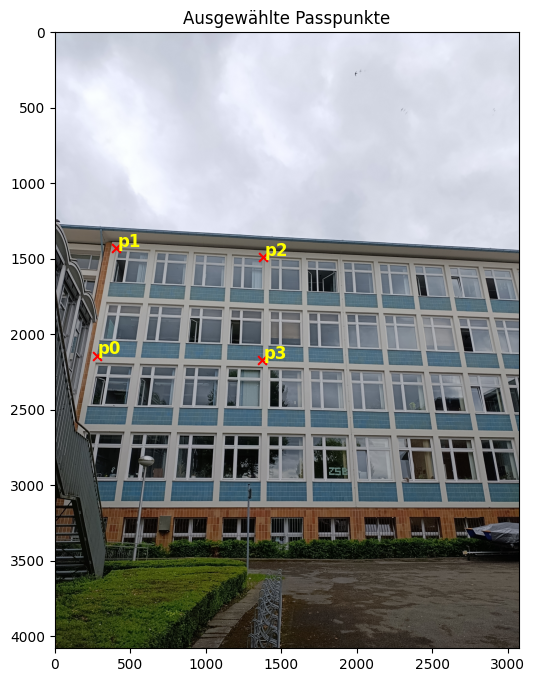


Gib die Weltkoordinaten zu den folgenden Bildpunkten ein.
Format: x y (getrennt durch Leerzeichen)


--- Bild 2 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=303, y=1935
p1: x=384, y=1200
p2: x=1392, y=1260
p3: x=1398, y=1953


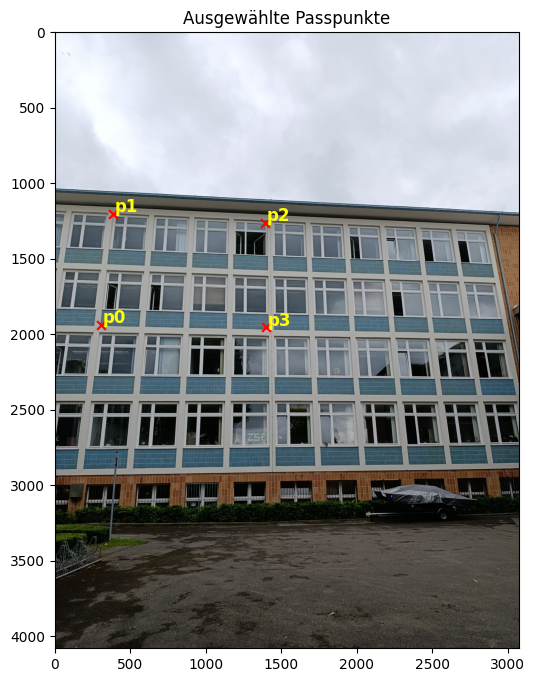


Gib die Weltkoordinaten zu den folgenden Bildpunkten ein.
Format: x y (getrennt durch Leerzeichen)


--- Bild 3 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=621, y=1890
p1: x=672, y=1146
p2: x=1953, y=1179
p3: x=2004, y=1902


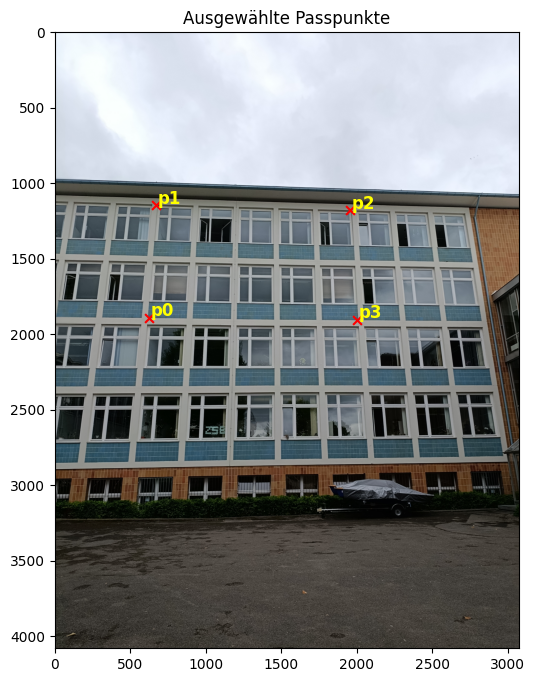


Gib die Weltkoordinaten zu den folgenden Bildpunkten ein.
Format: x y (getrennt durch Leerzeichen)

Ungültige Eingabe. Bitte zwei Zahlen eingeben, z. B.: 100 250

--- Bild 4 ---
Wähle mindestens 4 Passpunkte (mehr ist besser). Drücke 'q' zum Beenden.
p0: x=1272, y=1890
p1: x=1305, y=1173
p2: x=2538, y=1191
p3: x=2637, y=1914


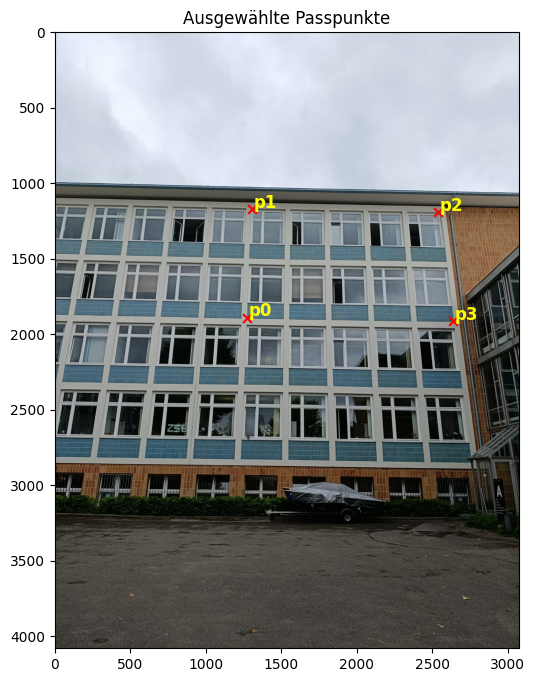


Gib die Weltkoordinaten zu den folgenden Bildpunkten ein.
Format: x y (getrennt durch Leerzeichen)



In [ ]:
perform_task(4)

In [5]:
def perform_task():

    # Bilddateien
    filenames = ["b1.jpg", "b2.jpg", "b3.jpg", "b4.jpg"]
    images = []
    control_points_list = []
    destination_points_list = []

    # Bild 1
    cps1 = [[276, 2139], [408, 1437], [1380, 1488], [1380, 2190]]
    dps1 = [[0, 3000], [0, 1500], [1800, 1500], [1800, 3000]]

    # Bild 2
    cps2 = [[294, 1944], [375, 1212], [1390, 1260], [1399, 1974]]
    dps2 = [[1800, 3000], [1800, 1500], [3600, 1500], [3600, 3000]]

    # Bild 3
    cps3 = [[618, 1887], [684, 1149], [1950, 1203], [2004, 1902]]
    dps3 = [[3600, 3000], [3600, 1500], [5400, 1500], [5400, 3000]]

    # Bild 4
    cps4 = [[1272, 1887], [1305, 1149], [2538, 1203], [2637, 1914]]
    dps4 = [[5400, 3000], [5400, 1500], [7200, 1500], [7200, 3000]]

    for i, fname in enumerate(filenames):
        if not os.path.exists(fname):
            print(f"Fehler: Datei {fname} nicht gefunden!")
            return

        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    control_points_list = [cps1, cps2, cps3, cps4]
    destination_points_list = [dps1, dps2, dps3, dps4]

    # Weltkoordinaten normalisieren (Offset für Bildgröße)
    all_world = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world, axis=0)
    max_x, max_y = np.max(all_world, axis=0)
    output_shape = (int(max_y - min_y) + 200, int(max_x - min_x) + 200)

    normalized_dps_list = []
    for dps in destination_points_list:
        normalized = [[x - min_x, y - min_y] for x, y in dps]
        normalized_dps_list.append(normalized)

    # Erstelle Panorama
    print("Panorama wird erzeugt...")
    panorama_simple = create_panorama(
        images,
        control_points_list,
        normalized_dps_list,
        output_shape,
        blend_method='avg',
        blending_type='simple'
    )

    panorama_multi = create_panorama(
        images,
        control_points_list,
        normalized_dps_list,
        output_shape,
        blend_method='avg',
        blending_type='multiband'
    )

    cv2.imwrite("panorama_simple_avg.jpg", cv2.cvtColor(panorama_simple, cv2.COLOR_RGB2BGR))
    cv2.imwrite("panorama_multiband.jpg", cv2.cvtColor(panorama_multi, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(panorama_simple)
    plt.title("Einfache Verschmelzung (AVG)")
    plt.subplot(122)
    plt.imshow(panorama_multi)
    plt.title("Multiband Blending")
    plt.tight_layout()
    plt.show()


Panorama wird erzeugt...


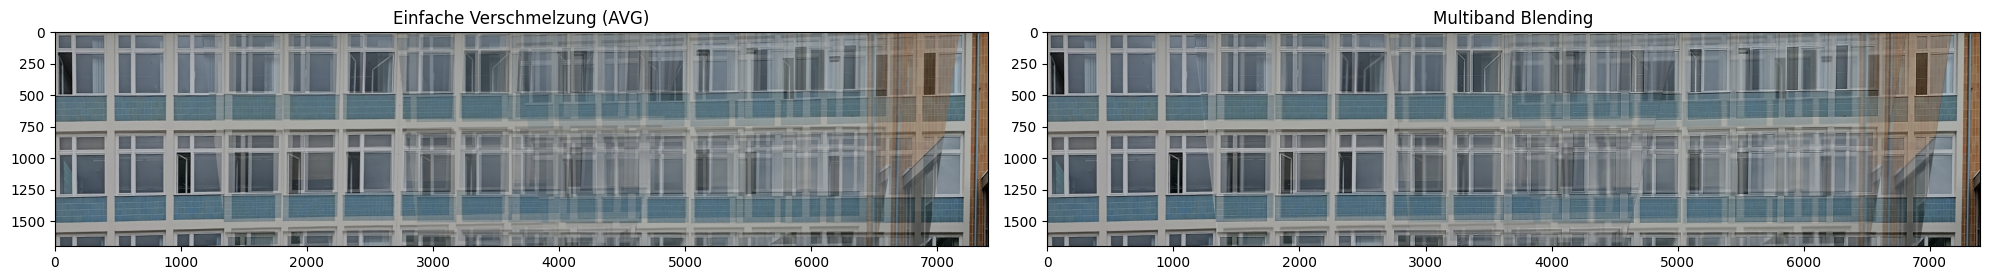

In [6]:
perform_task()

In [9]:
def perform_task():

    # Bilddateien
    filenames = ["b1.jpg", "b2.jpg", "b3.jpg", "b4.jpg"]
    images = []
    control_points_list = []
    destination_points_list = []

    # Bild 1
    cps1 = [[276, 2139], [408, 1437], [1380, 1488], [1380, 2190]]
    dps1 = [[0, 3000], [0, 1500], [1800, 1500], [1800, 3000]]

    # Bild 2
    cps2 = [[294, 1944], [375, 1212], [1390, 1260], [1399, 1974]]
    dps2 = [[1800, 3000], [1800, 1500], [3600, 1500], [3600, 3000]]

    # Bild 3
    cps3 = [[618, 1887], [684, 1149], [1950, 1203], [2004, 1902]]
    dps3 = [[3600, 3000], [3600, 1500], [5400, 1500], [5400, 3000]]

    # Bild 4
    cps4 = [[1272, 1887], [1305, 1149], [2538, 1203], [2637, 1914]]
    dps4 = [[5400, 3000], [5400, 1500], [7200, 1500], [7200, 3000]]

    for i, fname in enumerate(filenames):
        if not os.path.exists(fname):
            print(f"Fehler: Datei {fname} nicht gefunden!")
            return

        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    control_points_list = [cps1, cps2, cps3, cps4]
    destination_points_list = [dps1, dps2, dps3, dps4]

    # Weltkoordinaten normalisieren (Offset für Bildgröße)
    all_world = np.vstack(destination_points_list)
    min_x, min_y = np.min(all_world, axis=0)
    max_x, max_y = np.max(all_world, axis=0)
    output_shape = (int(max_y - min_y) + 200, int(max_x - min_x) + 200)

    normalized_dps_list = []
    for dps in destination_points_list:
        normalized = [[x - min_x, y - min_y] for x, y in dps]
        normalized_dps_list.append(normalized)

    # Erstelle Panorama
    print("Panorama wird erzeugt...")
    panorama_simple = create_panorama(
        images,
        control_points_list,
        normalized_dps_list,
        output_shape,
        blend_method='avg',
        blending_type='simple'
    ) 
    panorama_simple_max = create_panorama(
        images,
        control_points_list,
        normalized_dps_list,
        output_shape,
        blend_method='max',
        blending_type='simple'
    )

    panorama_multi = create_panorama(
        images,
        control_points_list,
        normalized_dps_list,
        output_shape,
        blend_method='avg',
        blending_type='multiband'
    )

    cv2.imwrite("panorama_simple_avg.jpg", cv2.cvtColor(panorama_simple, cv2.COLOR_RGB2BGR))
    cv2.imwrite("panorama_simple_max.jpg", cv2.cvtColor(panorama_simple_max, cv2.COLOR_RGB2BGR))
    cv2.imwrite("panorama_multiband.jpg", cv2.cvtColor(panorama_multi, cv2.COLOR_RGB2BGR))

    plt.figure(figsize=(15, 20))
    plt.subplot(3, 1, 1)
    plt.imshow(panorama_simple)
    plt.title("Einfache Verschmelzung (AVG)")
    plt.subplot(3, 1, 2)
    plt.imshow(panorama_simple_max)
    plt.title("Einfache Verschmelzung (MAX)")
    plt.subplot(3, 1, 3)
    plt.imshow(panorama_multi)
    plt.title("Multiband Blending")
    plt.tight_layout()
    plt.show()


Panorama wird erzeugt...


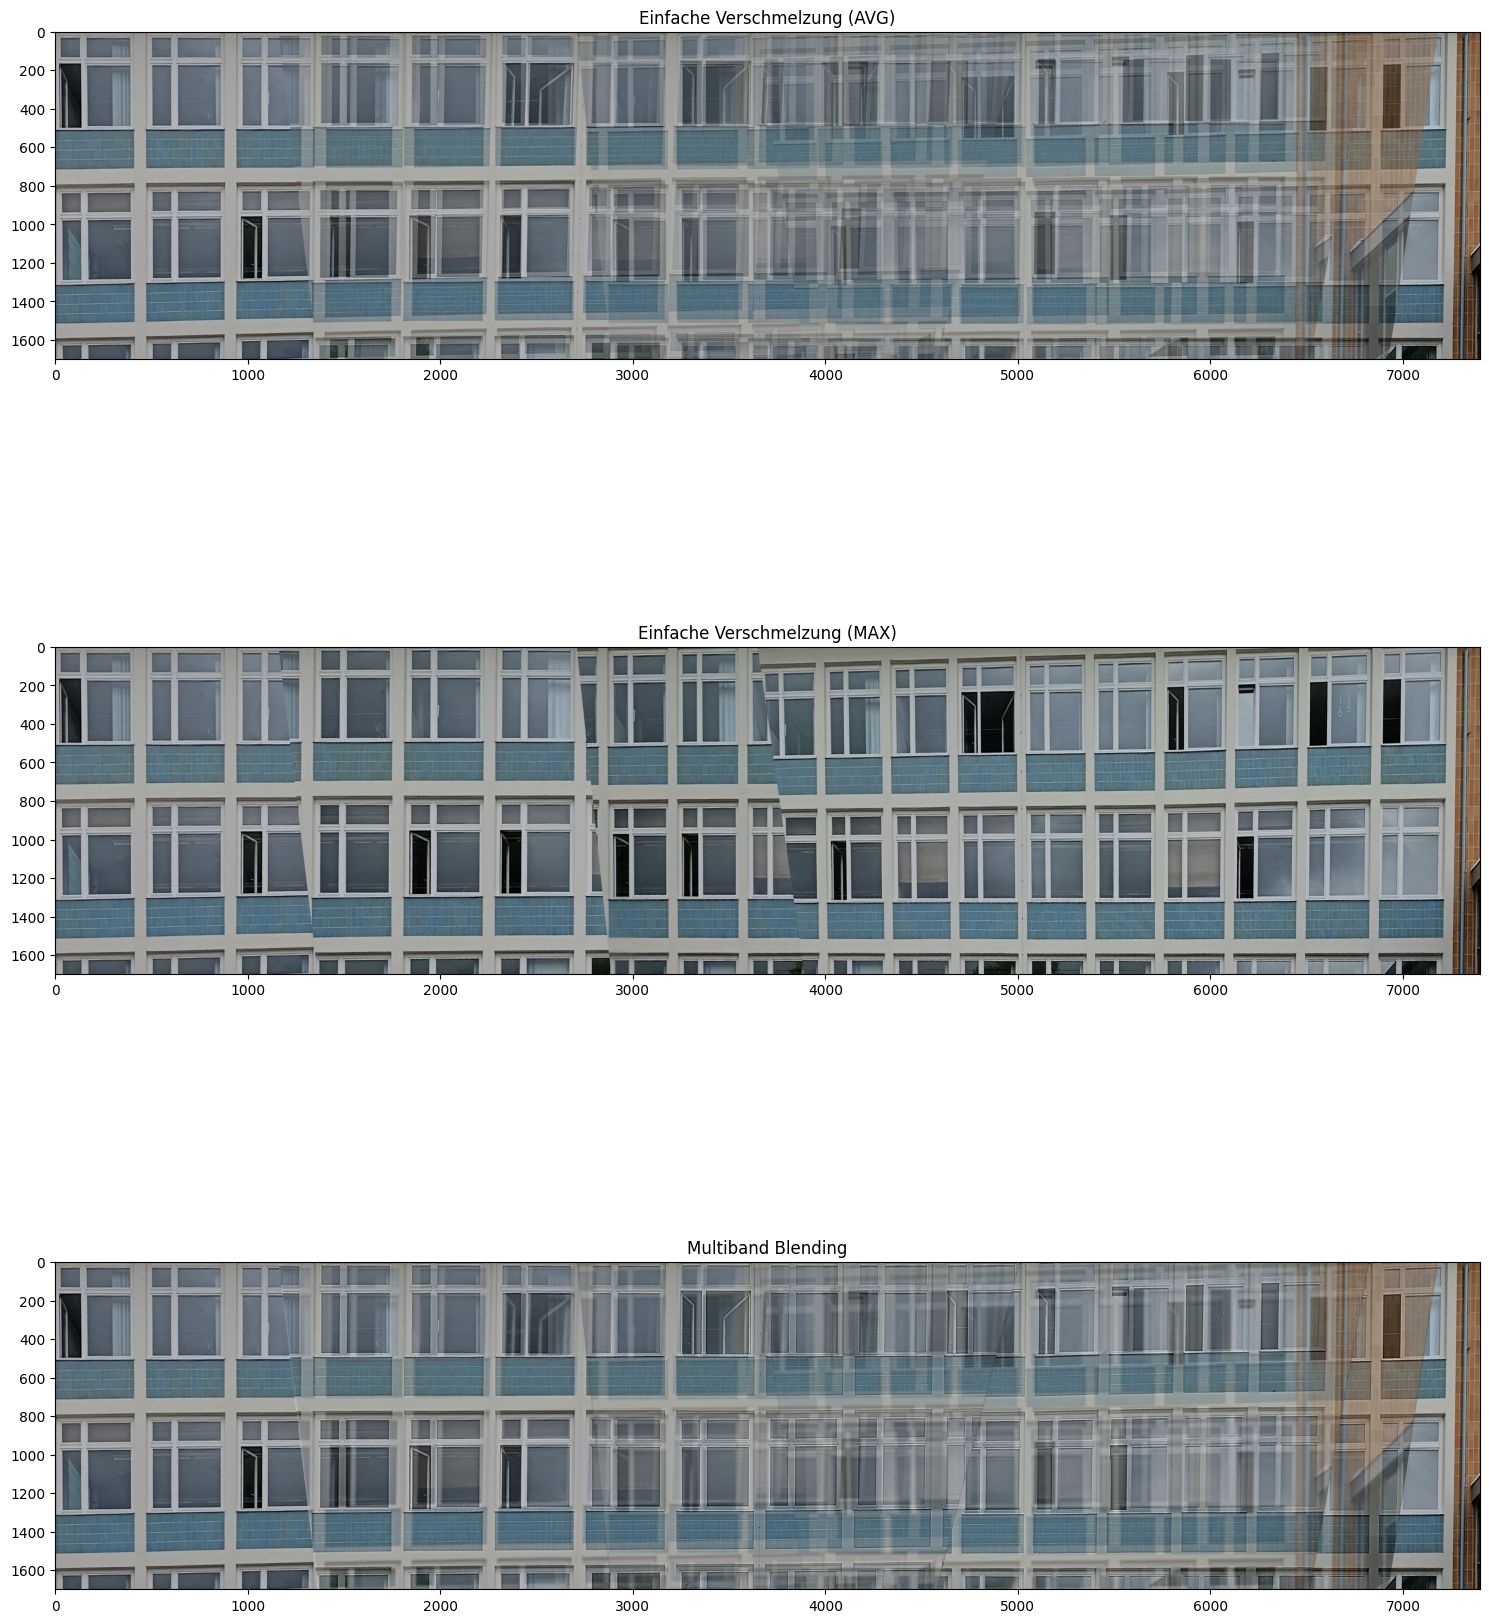

In [10]:
perform_task()